# K-Means Clustering From Scratch

## 1. Introduction

Clustering is a type of **unsupervised machine learning**, which means we work with data **without labels**. The goal is to discover hidden patterns or groupings inside the data.

**K-Means** is one of the most popular clustering algorithms. It groups data points into **K clusters** based on similarity. Each cluster is represented by a **centroid**, which is simply the average position of all points inside that cluster.

In this notebook, we will:

- Understand how K-Means works intuitively
- Implement K-Means from scratch using NumPy only
- Visualize every step of the algorithm
- Test our implementation on real data

## 2. How K-Means Works (High-Level Idea)

K-Means follows a simple iterative process:

1. Choose K (number of clusters)
2. Randomly initialize K centroids
3. Assign each data point to the nearest centroid
4. Recalculate centroids as the mean of assigned points
5. Repeat steps 3 and 4 until centroids stop changing

When the centroids no longer move, the algorithm has **converged**.

## 3. Import Required Libraries

We only need `NumPy` for computation and `Matplotlib` for visualization.

In [1]:
from typing import List

import numpy as np
import matplotlib.pyplot as plt

## 4. Distance Function (Euclidean Distance)

To know which cluster a data point belongs to, we measure how far it is from each centroid.

We use Euclidean distance, which is the straight-line distance between two points.

In [2]:
def euclidean_distance(x1: np.ndarray, x2: np.ndarray) -> float:
    """
    Compute the Euclidean distance between two points.
    
    :param x1: np.ndarray
        First point (vector)
    :param x2: np.ndarray
        Second point (vector)
    :return: float
        Euclidean distance between x1 and x2
    """
    return np.sqrt(np.sum((x1 - x2) ** 2))

## 5. KMeans Class — Overview

We now build our own KMeans class, similar in spirit to scikit-learn, but much simpler and fully transparent.

The class will:

- Initialize parameters
- Assign points to clusters
- Update centroids
- Check for convergence
- Optionally visualize each step

In [3]:
class KMeans:
    def __init__(self, k: int = 5, max_iters: int = 100, plot_steps: bool = False):
        """
        K-Means clustering algorithm implemented from scratch.
        
        :param k: int
            Number of clusters
        :param max_iters: int
            Maximum number of iterations
        :param plot_steps: bool
            Whether to plot intermediate steps
        """

        self.k = k
        self.max_iters = max_iters
        self.plot_steps = plot_steps

        # Will hold indices of samples for each cluster
        self.clusters = [[] for _ in range(self.k)]

        # Will hold centroids vectors
        self.centroids = []

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Perform K-Means clustering on the dataset.
        
        :param X: ndarray
            Input data of shape (n_samples, n_features)
        :return: ndarray
            Cluster label for each data point
        """

        self.X = X
        self.n_samples, self.n_features = X.shape

        # Step 1: Randomly initialize centroids
        random_samples_idxs = np.random.choice(self.n_samples, self.k, replace=False)
        self.centroids = [self.X[idx] for idx in random_samples_idxs]

        # Step 2: Optimize loop
        for _ in range(self.max_iters):
            # Assign points to the closest centroid
            self.clusters = self._create_clusters(self.centroids)

            if self.plot_steps:
                self.plot()

            # Store old centroids
            old_centroids = self.centroids

            # Compute new centroids
            self.centroids = self._get_centroids(self.clusters)

            # Check convergence
            if self._is_converged(old_centroids, self.centroids):
                break

        # Return final cluster labels
        return self._get_cluster_labels(self.clusters)

    def _create_clusters(self, centroids: List[List[int]] | np.ndarray) -> List[List[int]]:
        """
        Assign each data point to the nearest centroid.
    
        :param centroids: list or np.ndarray
            Current centroid vectors
        :return: list[list[int]]
            List of clusters, where each cluster contains indices
            of samples assigned to that centroid
        """
        clusters = [[] for _ in range(self.k)]

        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)

        return clusters

    def _closest_centroid(self, sample: np.ndarray, centroids: List | np.ndarray) -> int:
        """
        Find the index of the closest centroid to a given sample.
        
        :param sample: np.ndarray
            Single data point
        :param centroids: list or np.ndarray
            Current centroid vectors
        :return: int
            Index of the nearest centroid
        """

        distances = [euclidean_distance(sample, point) for point in centroids]
        return np.argmin(distances)

    def _get_centroids(self, clusters: List[List[int]]) -> np.ndarray:
        """
        Compute updated centroids for each cluster.
        
        :param clusters: list[list[int]]
            Clusters containing indices of assigned samples
        :return: np.ndarray
            Updated centroid vectors
        """

        centroids = np.zeros((self.k, self.n_features))

        for cluster_idx, cluster in enumerate(clusters):
            if len(cluster) > 0:
                centroids[cluster_idx] = np.mean(self.X[cluster], axis=0)
            else:
                # Reinitialize centroid if cluster is empty
                random_idx = np.random.choice(self.n_samples)
                centroids[cluster_idx] = self.X[random_idx]

        return centroids

    def _is_converged(self, old_centroids: List | np.ndarray, centroids: List | np.ndarray) -> bool:
        """
        Check whether the centroids have converged.
        
        :param old_centroids: list or np.ndarray
            Centroid vectors from the previous iteration
        :param centroids: list or np.ndarray
            Updated centroid vectors
        :return: bool
            True if centroids have stopped changing, False otherwise 
        """

        distances = [euclidean_distance(old_centroids[i], centroids[i]) for i in range(self.k)]
        return np.sum(distances) == 0

    def _get_cluster_labels(self, clusters: List[List[int]]) -> np.ndarray:
        """
        Convert cluster assignments into a label array.
        
        :param clusters: list[list[int]]
            Clusters containing indices of assigned samples
        :return: np.ndarray
            Array of cluster labels for each sample
        """

        labels = np.empty(self.n_samples)

        for cluster_idx, cluster in enumerate(clusters):
            for sample_idx in cluster:
                labels[sample_idx] = cluster_idx

        return labels

    def plot(self):
        """
        Visualize current clusters and centroids.
    
        Displays a 2D scatter plot of data points colored by cluster
        assignment, with centroids shown as black crosses.
        """
        fig, ax = plt.subplots(figsize=(10, 7))

        for cluster in self.clusters:
            if len(cluster) > 0:
                points = self.X[cluster]
                ax.scatter(points[:, 0], points[:, 1])

        centroids = np.array(self.centroids)
        ax.scatter(
            centroids[:, 0], centroids[:, 1],
            marker='x', color='black', s=200, linewidth=3
        )

        ax.set_title("K-Means Clustering")
        plt.show()

# 6. Testing the Algorithm on Real Data

We use `make_blobs` to generate synthetic clusterable data.

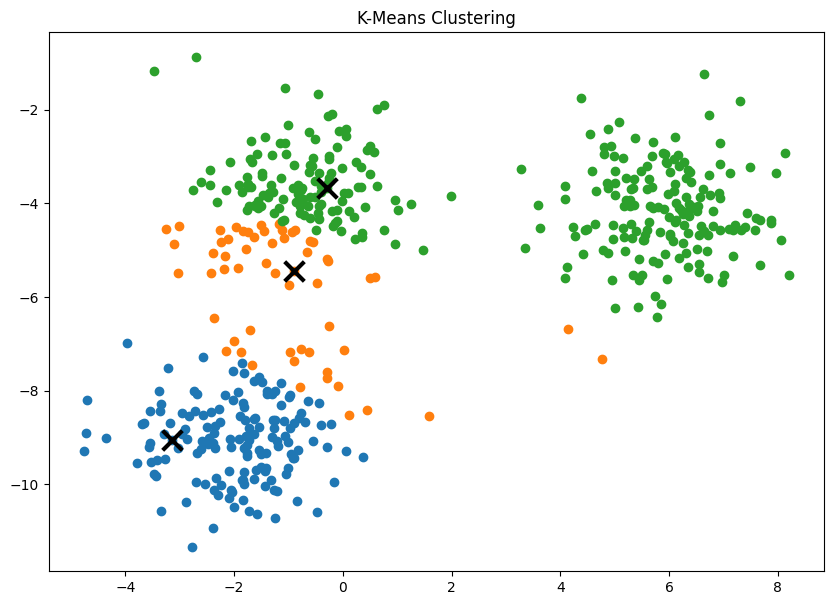

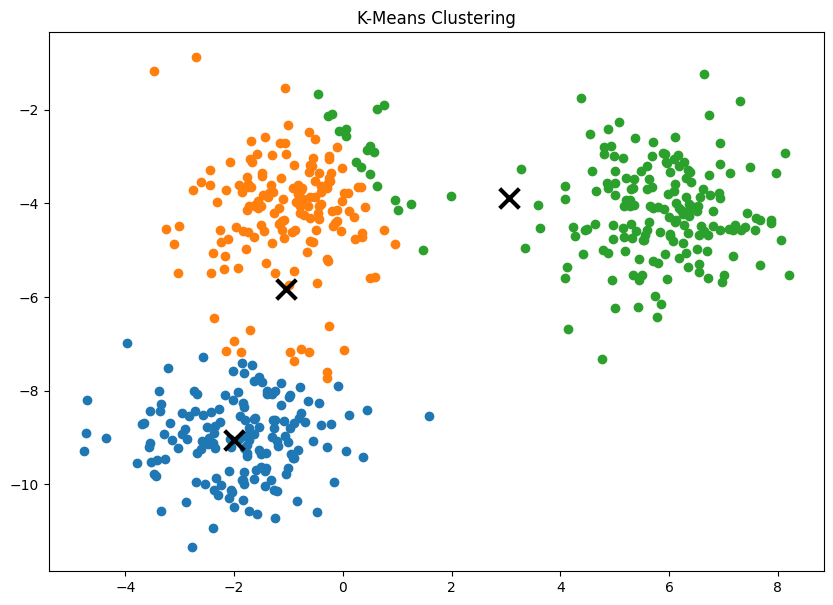

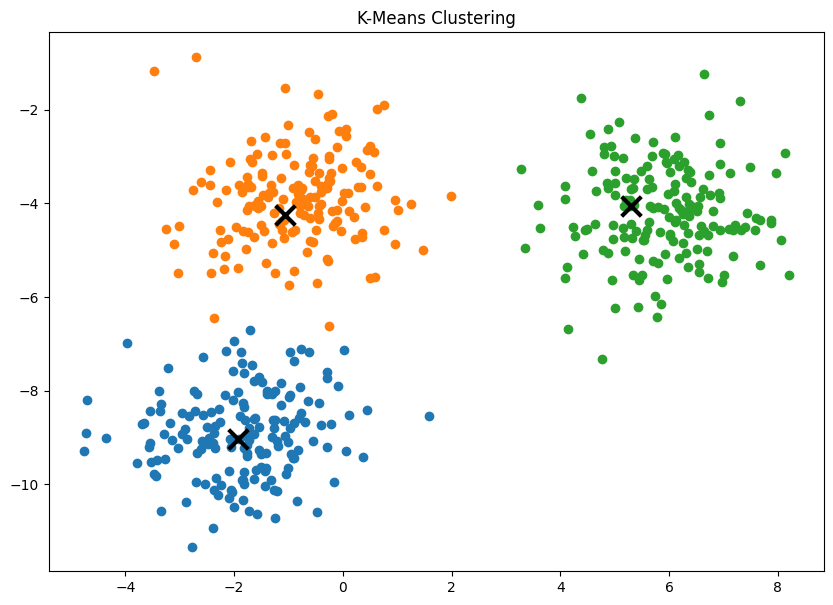

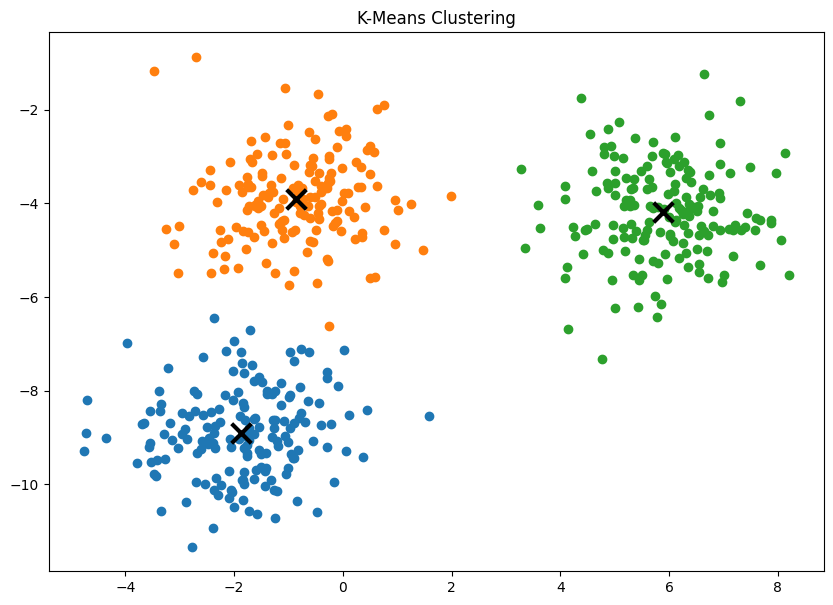

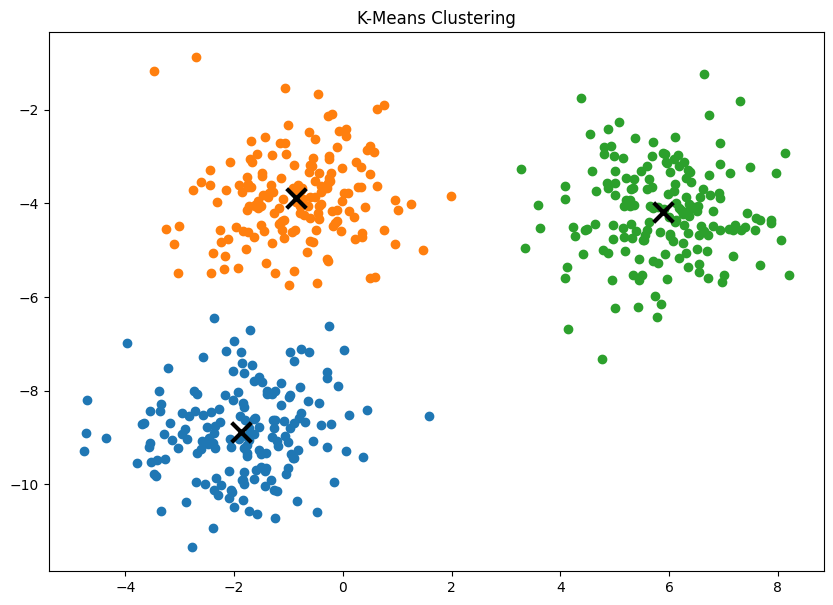

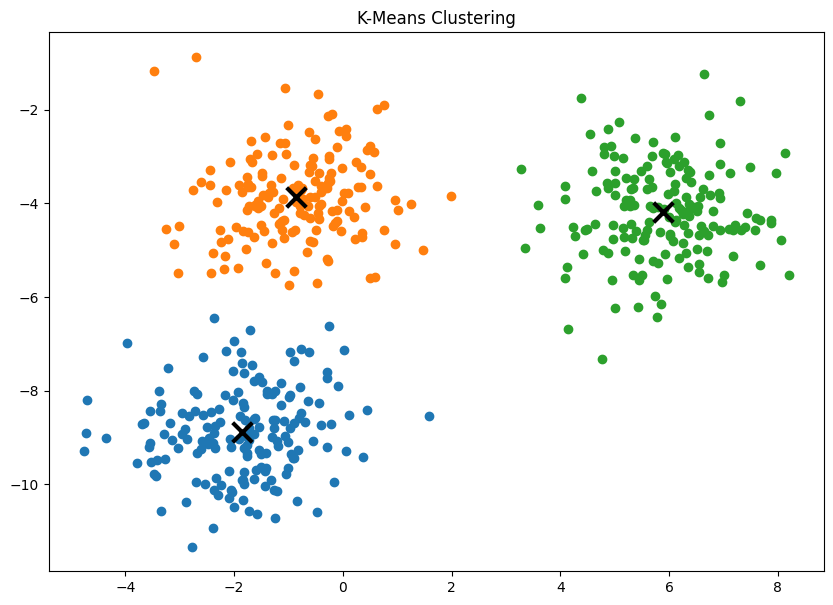

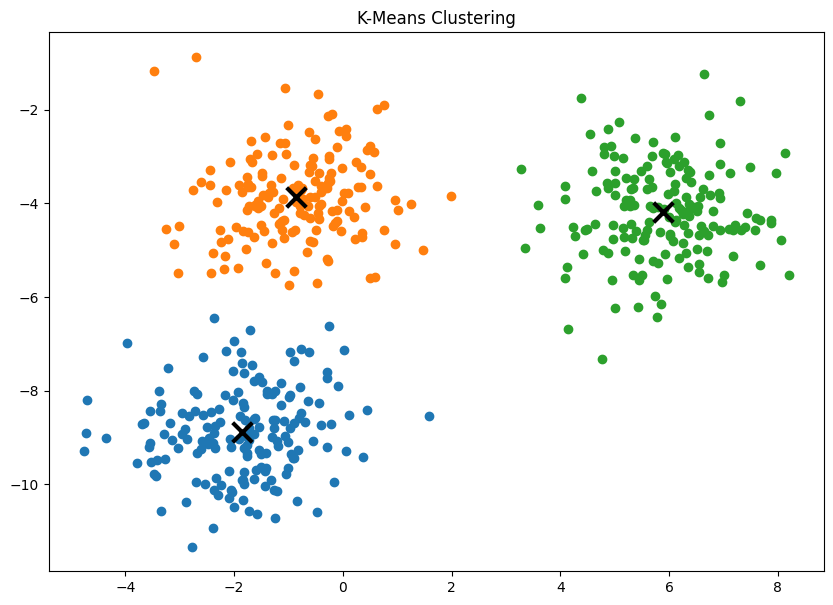

Adjusted Rand Index: 0.9880


In [4]:
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score

np.random.seed(42)

X, y = make_blobs(
    centers=3,
    n_samples=500,
    n_features=2,
    random_state=40
)

kmeans = KMeans(k=3, max_iters=150, plot_steps=True)
y_pred = kmeans.predict(X)

kmeans.plot()

ari = adjusted_rand_score(y, y_pred)
print(f"Adjusted Rand Index: {ari:.4f}")